# Zillow Home Value (Zestimate) Prediction in ML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Zillow.csv')
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,target
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940


In [3]:
df.shape

(77613, 59)

## Data Cleaning

In [4]:
to_remove = []
for col in df.columns:

    # Removing columns having only one value.
    if df[col].nunique() == 1:
        to_remove.append(col)

    # Removing columns with more than 90% of the
    # rows as null values.
    elif (df[col].isnull()).mean() > 0.60:
        to_remove.append(col)

print(len(to_remove))

30


In [5]:
df.drop(to_remove,
        axis=1,
        inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   bathroomcnt                   77579 non-null  float64
 2   bedroomcnt                    77579 non-null  float64
 3   buildingqualitytypeid         49809 non-null  float64
 4   calculatedbathnbr             76963 non-null  float64
 5   calculatedfinishedsquarefeet  77378 non-null  float64
 6   finishedsquarefeet12          73923 non-null  float64
 7   fips                          77579 non-null  float64
 8   fullbathcnt                   76963 non-null  float64
 9   heatingorsystemtypeid         49571 non-null  float64
 10  latitude                      77579 non-null  float64
 11  longitude                     77579 non-null  float64
 12  lotsizesquarefeet             69321 non-null  float64
 13  p

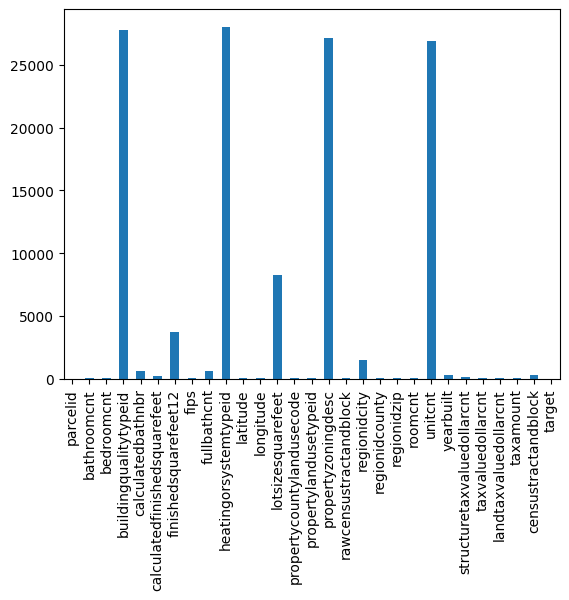

In [7]:
df.isnull().sum().plot.bar()
plt.show()

In [8]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    elif df[col].dtype == np.number:
        df[col] = df[col].fillna(df[col].mean())

df.isnull().sum().sum()

np.int64(0)

## Exploratory Data Analysis

In [9]:
ints, objects, floats = [], [], []

for col in df.columns:
    if df[col].dtype == float:
        floats.append(col)
    elif df[col].dtype == int:
        ints.append(col)
    else:
        objects.append(col)

len(ints), len(floats), len(objects)

(1, 26, 2)

In [10]:
for col in objects:
    print(col, ' -> ', df[col].nunique())
    print(df[col].unique())
    print()

propertycountylandusecode  ->  75
['122' '1110' '0101' '010C' '1129' '0100' '38' '34' '1111' '012C' '010V'
 '1' '0103' '010D' '0200' '010E' '0300' '96' '0104' '0400' '01DC' '01HC'
 '1321' '1410' '0108' '1128' '010G' '1720' '010H' '1210' '0102' '010F'
 '010M' '1117' '0201' '0700' '1722' '73' '0109' '0301' '01HE' '135' '0204'
 '0401' '070D' '0113' '0133' '0131' '1432' '040G' '1112' '1222' '1310'
 '1120' '0111' '1116' '1421' '0110' '0105' '012E' '0141' '1333' '0115'
 '040V' '010L' '040B' '012D' '0114' '0203' '030G' '0130' '105' '020G'
 '020M' '020E']

propertyzoningdesc  ->  1907
['LAR1' 'LCR110000*' 'LAR3' ... 'HAR4-R2*' 'LCR1VV' 'BFA15000*']



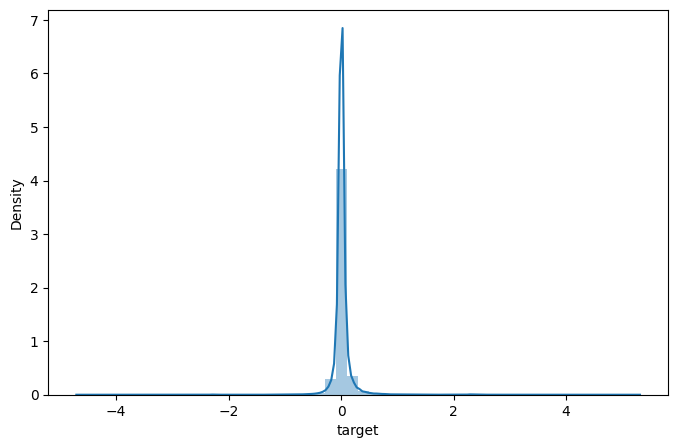

In [11]:
plt.figure(figsize=(8, 5))
sb.distplot(df['target'])
plt.show()

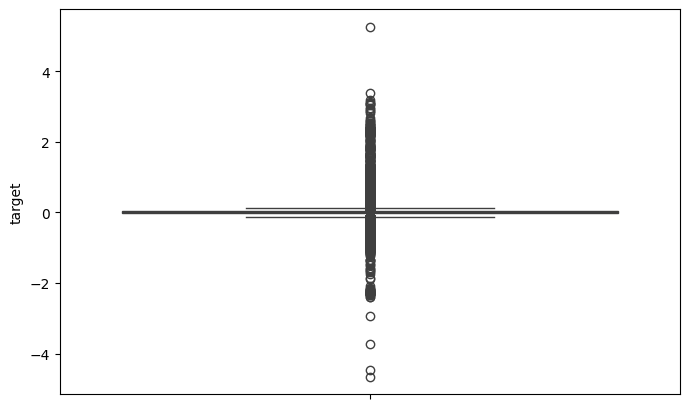

In [12]:
plt.figure(figsize=(8, 5))
sb.boxplot(df['target'])
plt.show()

In [13]:
print('Shape of the dataframe before removal of outliers', df.shape)
df = df[(df['target'] > -1) & (df['target'] < 1)]
print('Shape of the dataframe after removal of outliers ', df.shape)

Shape of the dataframe before removal of outliers (77613, 29)
Shape of the dataframe after removal of outliers  (77261, 29)


In [14]:
for col in objects:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

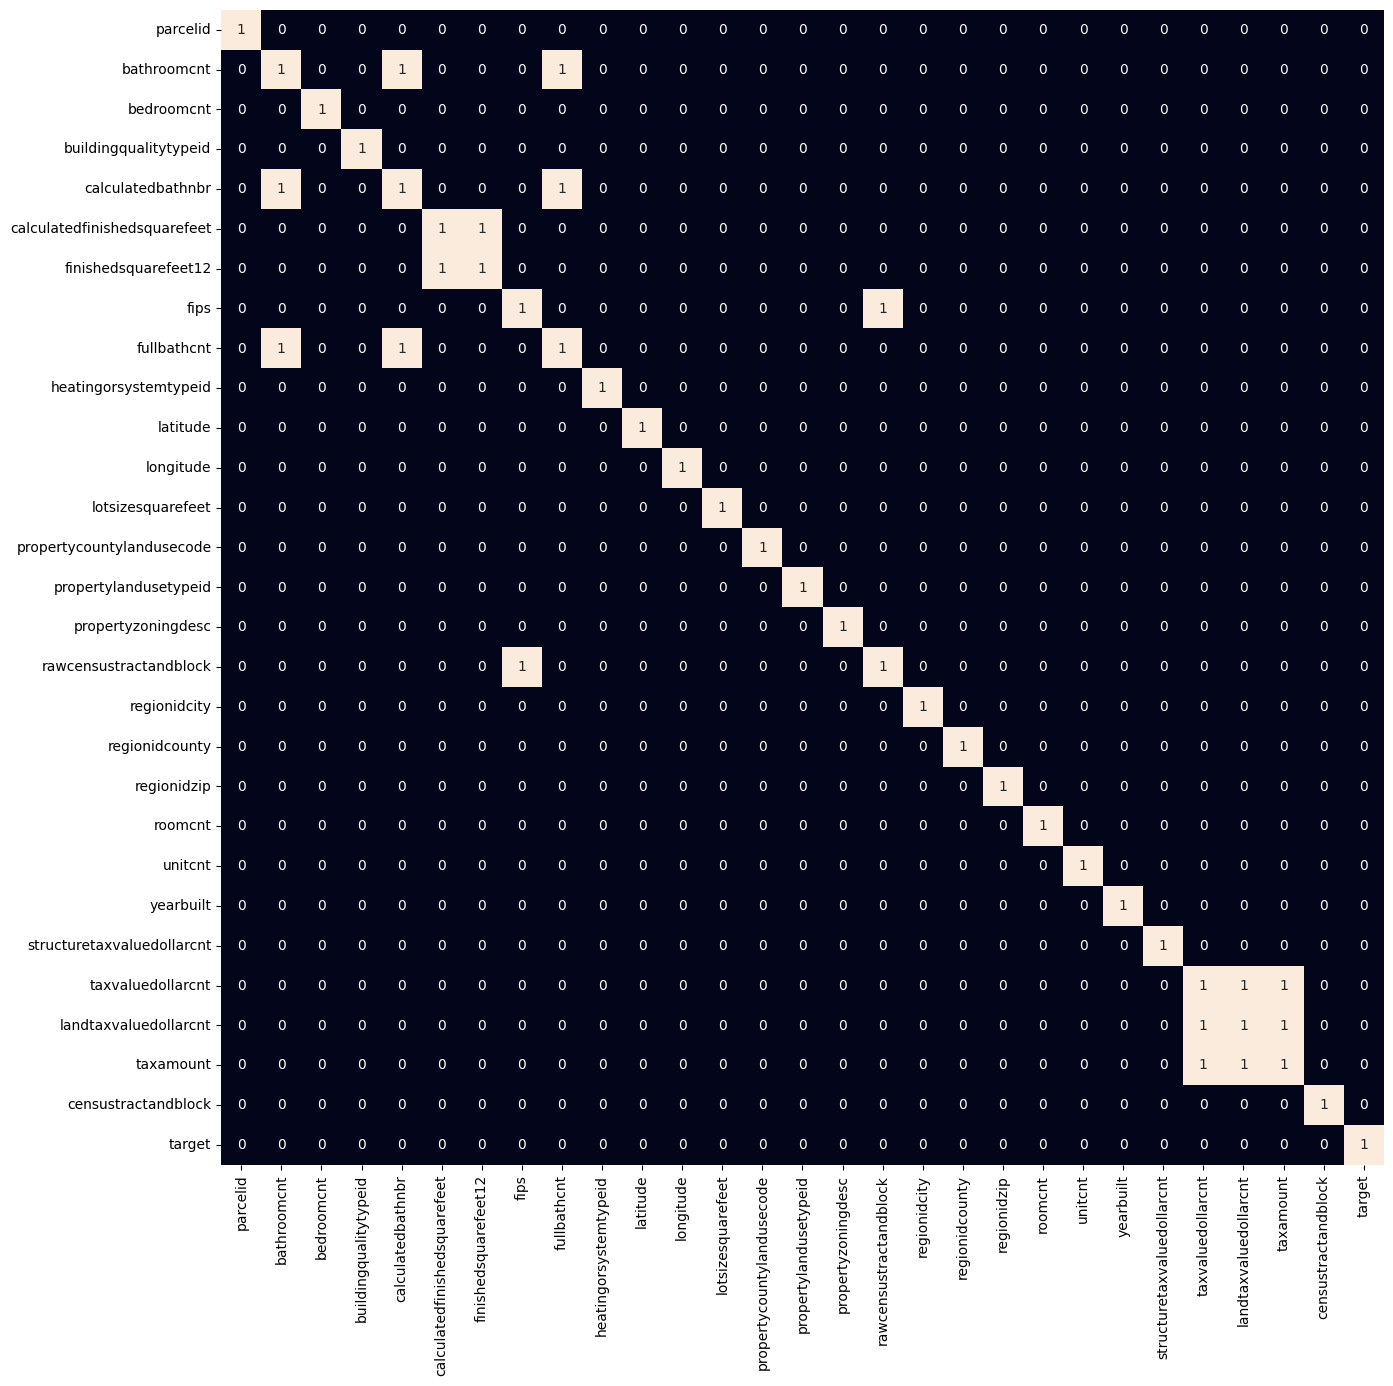

In [15]:
plt.figure(figsize=(15, 15))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [16]:
to_remove = ['calculatedbathnbr', 'fullbathcnt', 'fips',
             'rawcensustractandblock', 'taxvaluedollarcnt',
             'finishedsquarefeet12', 'landtaxvaluedollarcnt']

df.drop(to_remove, axis=1, inplace=True)

## Model Training

In [17]:
features = df.drop(['parcelid'], axis=1)
target = df['target'].values

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.1,
                                      random_state=22)
X_train.shape, X_val.shape

((69534, 21), (7727, 21))

In [18]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
models = [LinearRegression(), XGBRegressor(),
          Lasso(), RandomForestRegressor(), Ridge()]

for i in range(5):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  9.295349470435582e-17
Validation Error :  9.1234195155332e-17

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) : 
Training Error :  0.0011615510279198217
Validation Error :  0.0020190995111265897

Lasso() : 
Training Error :  0.06232063320274573
Validation E